In [1]:
import wmi
import psutil
import pandas as pd
import datetime
import os
import time
import random
duration_minutes = 15
sampling_rate_hz = 10
num_samples = duration_minutes * 10 * sampling_rate_hz
# Start time
start_time = datetime.datetime.now()
# Initialize WMI client
w = wmi.WMI(namespace="root\\OpenHardwareMonitor")

In [2]:
timestamps = []
cpu_temperatures = []
cpu_usages = []
cpu_loads = []
memory_usages = []
battery_levels = []
cpu_powers = []

for i in range(num_samples):
    try:
        current_time = datetime.datetime.now()
        timestamps.append(current_time)

        sensor_info = w.Sensor()
        cpu_temp = None
        cpu_power = None
        for sensor in sensor_info:
            if sensor.SensorType == 'Temperature' and 'CPU' in sensor.Name:
                cpu_temp = sensor.Value
            if sensor.SensorType == 'Power' and 'CPU Package' in sensor.Name:
                cpu_power = sensor.Value
        cpu_temperatures.append(cpu_temp)
        cpu_powers.append(cpu_power)

        cpu_usage = psutil.cpu_percent(interval=1 / sampling_rate_hz)
        cpu_usages.append(cpu_usage)

        try:
            cpu_load = psutil.getloadavg()[0]
        except AttributeError:
            cpu_load = None  # Handle platforms where getloadavg isn't available
        cpu_loads.append(cpu_load)

        memory_usage = psutil.virtual_memory().percent
        memory_usages.append(memory_usage)

        battery = psutil.sensors_battery()
        battery_level = battery.percent if battery else None
        battery_levels.append(battery_level)

        if random.random() < 0.1: 
            # Introduce high CPU usage
            cpu_usages[-1] = random.uniform(90, 100)  
        if random.random() < 0.1:
            # Introduce high temperature
            cpu_temperatures[-1] = random.uniform(90, 105)  
        if random.random() < 0.1:
            # Introduce high memory usage
            memory_usages[-1] = random.uniform(95, 100)  
        if random.random() < 0.1:
            # Introduce low battery level
            battery_levels[-1] = random.uniform(0, 10)  # Low battery level
        if random.random() < 0.1:
            # Introduce high CPU power
            cpu_powers[-1] = random.uniform(50, 100)  # Unusually high CPU power

    except Exception as e:
        print(f"Error collecting data: {e}")
        # Append None for all metrics to maintain consistency
        cpu_temperatures.append(None)
        cpu_usages.append(None)
        cpu_loads.append(None)
        memory_usages.append(None)
        battery_levels.append(None)
        cpu_powers.append(None)

data = {
    'timestamp': timestamps,
    'cpu_temperature': cpu_temperatures,
    'cpu_usage': cpu_usages,
    'cpu_load': cpu_loads,
    'memory_usage': memory_usages,
    'battery_level': battery_levels,
    'cpu_power': cpu_powers
}
df_real = pd.DataFrame(data)

output_dir = r'C:\My_file'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save DataFrame to CSV
csv_path = os.path.join(output_dir, 'hardware_monitor_15.csv')
df_real.to_csv(csv_path, mode='a', index=False)
print(f"Data saved to {csv_path}")




Data saved to C:\My_file\hardware_monitor_15.csv


In [24]:
dataset = pd.read_csv("hardware_monitor_15.csv")
dataset.head()

timestamp  cpu_temperature  cpu_usage  cpu_load  \
0  2024-12-02 21:24:59.087518        93.367452   33.30000       0.0   
1  2024-12-02 21:25:00.300513        92.946137   60.00000       0.0   
2  2024-12-02 21:25:01.001302        52.000000   25.90000       0.0   
3  2024-12-02 21:25:01.690613        52.000000   98.23542       0.0   
4  2024-12-02 21:25:02.309377        57.000000   51.90000       0.0   

   memory_usage  battery_level  cpu_power  
0     87.400000       8.000000   7.200207  
1     87.300000       8.000000   7.390545  
2     87.400000       0.046781   7.724777  
3     87.400000       8.000000   7.724777  
4     95.536855       1.178216   8.147902

In [26]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        1500 non-null   object 
 1   cpu_temperature  1500 non-null   float64
 2   cpu_usage        1500 non-null   float64
 3   cpu_load         1500 non-null   float64
 4   memory_usage     1500 non-null   float64
 5   battery_level    1500 non-null   float64
 6   cpu_power        1500 non-null   float64
dtypes: float64(6), object(1)
memory usage: 82.2+ KB


In [28]:
dataset.isnull().sum()

timestamp          0
cpu_temperature    0
cpu_usage          0
cpu_load           0
memory_usage       0
battery_level      0
cpu_power          0
dtype: int64

In [30]:
dataset.describe()

cpu_temperature    cpu_usage     cpu_load  memory_usage  battery_level  \
count      1500.000000  1500.000000  1500.000000   1500.000000    1500.000000   
mean         63.136654    29.191587     5.907807     87.307019       5.732935   
std          13.581072    32.796066     5.988229      3.291071       2.221746   
min           0.000000     0.000000     0.000000     82.300000       0.046781   
25%          55.000000     4.200000     2.590000     85.700000       3.000000   
50%          59.000000    14.800000     3.660000     86.700000       7.000000   
75%          65.000000    40.700000     7.270000     87.200000       8.000000   
max         104.980073   100.000000    35.510000     99.971254       9.927680   

         cpu_power  
count  1500.000000  
mean     13.822616  
std      19.546979  
min       0.000000  
25%       7.324599  
50%       8.035537  
75%       8.956884  
max      98.624553

In [32]:
from sklearn.ensemble import IsolationForest
import numpy as np

In [36]:
# Convert timestamp to datetime
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

In [38]:
# Replace extreme/invalid values (e.g., CPU temperature = 0) with NaN and interpolate
numeric_cols = ['cpu_temperature', 'cpu_usage', 'cpu_load', 'memory_usage', 'battery_level', 'cpu_power']
dataset[numeric_cols] = dataset[numeric_cols].replace(0, np.nan)
dataset[numeric_cols] = dataset[numeric_cols].interpolate(method='linear', limit_direction='forward')

In [40]:
# Apply Isolation Forest for anomaly detection on selected features
features = ['cpu_temperature', 'cpu_usage', 'memory_usage', 'cpu_power']
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = isolation_forest.fit_predict(dataset[features])

In [42]:
# Add anomaly labels to the dataset (-1 for anomaly, 1 for normal)
dataset['anomaly'] = anomaly_labels

In [44]:
# Count anomalies and normal points
anomaly_count = dataset['anomaly'].value_counts()
dataset.head(), anomaly_count

(                   timestamp  cpu_temperature  cpu_usage  cpu_load  \
 0 2024-12-02 21:24:59.087518        93.367452   33.30000       NaN   
 1 2024-12-02 21:25:00.300513        92.946137   60.00000       NaN   
 2 2024-12-02 21:25:01.001302        52.000000   25.90000       NaN   
 3 2024-12-02 21:25:01.690613        52.000000   98.23542       NaN   
 4 2024-12-02 21:25:02.309377        57.000000   51.90000       NaN   
 
    memory_usage  battery_level  cpu_power  anomaly  
 0     87.400000       8.000000   7.200207        1  
 1     87.300000       8.000000   7.390545        1  
 2     87.400000       0.046781   7.724777        1  
 3     87.400000       8.000000   7.724777        1  
 4     95.536855       1.178216   8.147902        1  ,
 anomaly
  1    1425
 -1      75
 Name: count, dtype: int64)

In [46]:
import matplotlib.pyplot as plt
import numpy as np


# Detect anomalies
mean_temp = dataset["cpu_temperature"].mean()
std_temp = dataset["cpu_temperature"].std()
anomalies_temp = dataset["cpu_temperature"][(dataset["cpu_temperature"] - mean_temp).abs() > 3 * std_temp]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(dataset["cpu_temperature"], label="Data", color="blue", alpha=0.7)
plt.scatter(anomalies_temp.index, anomalies_temp, color="red", label="Anomalies")
plt.title("CPU Temperature with Anomalies Highlighted")
plt.xlabel("Index")
plt.ylabel("CPU Temperature (°C)")
plt.legend()
plt.show()


In [48]:
# Detect anomalies
mean_usage = dataset["cpu_usage"].mean()
std_usage = dataset["cpu_usage"].std()
anomalies_usage = dataset["cpu_usage"][(dataset["cpu_usage"] - mean_usage).abs() > 3 * std_usage]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(data["cpu_usage"], label="Data", color="blue", alpha=0.7)
plt.scatter(anomalies_usage.index, anomalies_usage, color="red", label="Anomalies")
plt.title("CPU Usage with Anomalies Highlighted")
plt.xlabel("Index")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.show()


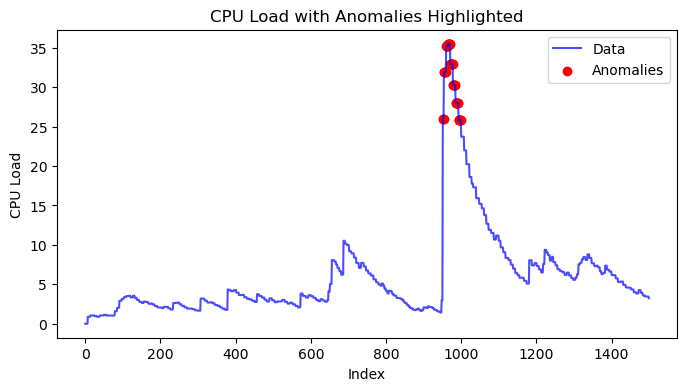

In [50]:
# Detect anomalies
mean_load = dataset["cpu_load"].mean()
std_load = dataset["cpu_load"].std()
anomalies_load = dataset["cpu_load"][(dataset["cpu_load"] - mean_load).abs() > 3 * std_load]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(data["cpu_load"], label="Data", color="blue", alpha=0.7)
plt.scatter(anomalies_load.index, anomalies_load, color="red", label="Anomalies")
plt.title("CPU Load with Anomalies Highlighted")
plt.xlabel("Index")
plt.ylabel("CPU Load")
plt.legend()
plt.show()


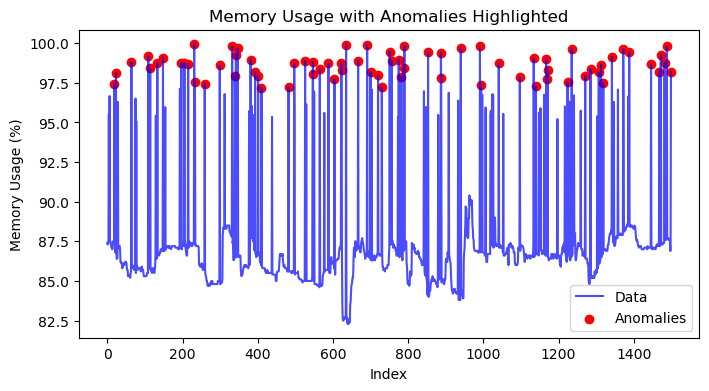

In [52]:
# Detect anomalies
mean_memory = dataset["memory_usage"].mean()
std_memory = dataset["memory_usage"].std()
anomalies_memory = dataset["memory_usage"][(dataset["memory_usage"] - mean_memory).abs() > 3 * std_memory]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(data["memory_usage"], label="Data", color="blue", alpha=0.7)
plt.scatter(anomalies_memory.index, anomalies_memory, color="red", label="Anomalies")
plt.title("Memory Usage with Anomalies Highlighted")
plt.xlabel("Index")
plt.ylabel("Memory Usage (%)")
plt.legend()
plt.show()


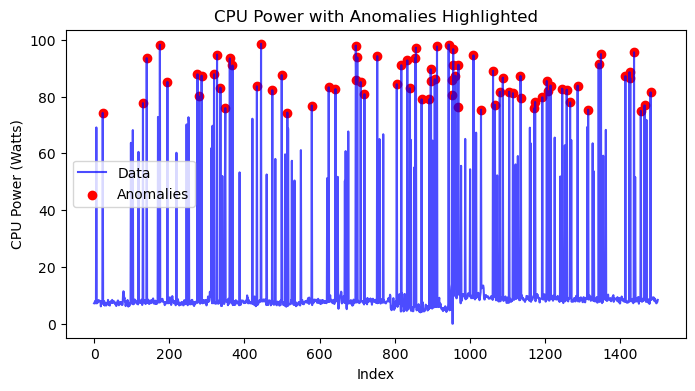

In [54]:
# Detect anomalies
mean_power = dataset["cpu_power"].mean()
std_power = dataset["cpu_power"].std()
anomalies_power = dataset["cpu_power"][(dataset["cpu_power"] - mean_power).abs() > 3 * std_power]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(data["cpu_power"], label="Data", color="blue", alpha=0.7)
plt.scatter(anomalies_power.index, anomalies_power, color="red", label="Anomalies")
plt.title("CPU Power with Anomalies Highlighted")
plt.xlabel("Index")
plt.ylabel("CPU Power (Watts)")
plt.legend()
plt.show()


In [ ]:
# Function to identify anomalies based on z-score
def detect_anomalies(series):
    mean = series.mean()
    std = series.std()
    z_score = (series - mean) / std
    anomalies = series[np.abs(z_score) > 3]
    return anomalies

# Identifying anomalies for each metric
anomalies = {
    "cpu_temperature": detect_anomalies(data["cpu_temperature"]),
    "cpu_usage": detect_anomalies(data["cpu_usage"]),
    "cpu_load": detect_anomalies(data["cpu_load"]),
    "memory_usage": detect_anomalies(data["memory_usage"]),
    "cpu_power": detect_anomalies(data["cpu_power"]),
}

# Plotting the metrics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Anomalies Detection in System Metrics", fontsize=16)

metrics = [
    ("cpu_temperature", "CPU Temperature (°C)"),
    ("cpu_usage", "CPU Usage (%)"),
    ("cpu_load", "CPU Load"),
    ("memory_usage", "Memory Usage (%)"),
    ("cpu_power", "CPU Power (Watts)"),
]

for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    ax.plot(dataset[metric], label="Data", color="blue", alpha=0.7)
    ax.scatter(
        anomalies[metric].index, anomalies[metric], label="Anomalies", color="red"
    )
    ax.set_title(f"{title} with Anomalies Highlighted")
    ax.set_xlabel("Index")
    ax.set_ylabel(title)
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.delaxes(axes[1, 2])  # Remove the last empty subplot
plt.show()
